# CVXPY - Convext Optimization for Everyone

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib
import pandas as pd
from scipy.stats import norm
from matplotlib import transforms, pyplot as plt
from typing import List
import warnings

# define frequently used colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2, ORANGE1 = '#C3514E', '#E6BAB7', '#F79747'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'

# configure font family and text appearance for all plots in this notebook
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

# turn all warnings off, don't do it in real projects
warnings.filterwarnings("ignore")

## Auxiliary Drawing Functions
Matplotlib doesn't have a function for drawing text with different colors, let's implement it.

In [2]:
def rainbow_text(x: float, y: float, s: str, colors: List[List[str]],
                 spacing: float = 20, ax=None, **kwargs):
    """Plots a text with different colors.

    Parameters
    __________
    x :
        The x position to place the text in data coordinates.
    y :
        The y position to place the text in data coordinates.
    s :
        The text in which each line is splat by \n and colored text parts
        are splat by ||.
    colors :
        The list of lists of colors. One list of colors per line.
    spacing :
        Spacing between text lines.
    ax :
        The axis to draw the text on.
    kwargs :
        Other miscellaneous text parameters.
    """
    colors = list(reversed(colors))
    transform = ax.transData
    canvas = ax.figure.canvas
    for line_num, line_text in enumerate(reversed(s.split('\n'))):
        line_text_parts = line_text.split('||')
        for line_text_part, color in zip(line_text_parts, colors[line_num]):
            text_obj = ax.text(x, y, line_text_part,
                               color=color, transform=transform, **kwargs)
            text_obj.draw(canvas.get_renderer())
            window_extent = text_obj.get_window_extent()
            transform = transforms.offset_copy(
                text_obj._transform, x=window_extent.width, units='dots')
        transform = transforms.offset_copy(
            ax.transData, x=0, y=(line_num + 1)*spacing, units='dots')

## Maximize Volume of a Box
A sheet of metal 12 inches by 10 inches is to be used to make a open box. Make a box of maximum volume.
![alt text](images/box_volume_optimization.jpg "Box volume optimization")

### Geometric Programming Solution

In [3]:
# we need to choose the box height, width and depth
height = cp.Variable(pos=True)
width = cp.Variable(pos=True)
depth = cp.Variable(pos=True)

# our objective is to maximize the box volume
objective = cp.Maximize(width*height*depth)
# a sheet of metal 12 inches by 10 inches constraints us
constraints = [depth + 2*height <= 12,
               width + 2*height <= 10]
# the task is to maximize the box volume within constraints
problem = cp.Problem(objective, constraints)
# do the task!
max_volume = problem.solve(gp=True)
print(f'Max volume {max_volume:.1f}, height={height.value:.1f}, '
      f'width={width.value:.1f}, depth={depth.value:.1f}')

Max volume 96.8, height=1.8, width=6.4, depth=8.4


### Convex Optimization Solution

In [4]:
h, w, d = cp.Variable(), cp.Variable(), cp.Variable()
objective = cp.Maximize(w + h + d)
constraints = [cp.log_sum_exp(cp.hstack([d, h + np.log(2)])) <= np.log(12),
               cp.log_sum_exp(cp.hstack([w, h + np.log(2)])) <= np.log(10)]
problem = cp.Problem(objective, constraints)
problem.solve()
h, w, d = np.exp(h.value), np.exp(w.value), np.exp(d.value)
print(f'Max volume {h*w*d:.1f}, height={h:.1f}, '
      f'width={w:.1f}, depth={d:.1f}')

Max volume 96.8, height=1.8, width=6.4, depth=8.4


## Portfolio Optimization
### Data

In [5]:
# we have $10,000 to invest
investment_amount = 10000
# we can spend $10,000 on any combination of these 7 stocks
stock_names = np.array(
    ['AFLT', 'GAZP', 'GMKN', 'ROSN', 'SBER', 'VTBR', 'YNDX'])
N = len(stock_names)
# expected returns on stock per day, for example: 0.00022 = 0.02%
expected_returns = np.array(
    [0.00022, 0.00283, 0.00143, 0.00038, 0.00027, 0.00140, 0.00091])
# what amount of money will we have in one day in the average case?
expected_gains = investment_amount * expected_returns
order = np.argsort(expected_gains)[::-1]
for name, gain in zip(stock_names[order], expected_gains[order]):
    print(f'{name}: ${gain:.1f}')

GAZP: $28.3
GMKN: $14.3
VTBR: $14.0
YNDX: $9.1
ROSN: $3.8
SBER: $2.7
AFLT: $2.2


In [6]:
# return volatilities per one day
daily_volatilities = np.array(
    [0.012042, 0.021330, 0.012767, 0.010863, 0.012807, 0.015556, 0.022450])
# I am 10% percent certain there will not be a loss of more than VaR dollars
share_gain_rvs = [
    norm(loc=investment_amount*loc, scale=investment_amount*scale)
    for loc, scale in zip(expected_returns, daily_volatilities)]
values_at_risk = np.abs(np.array(
    [rv.ppf(0.1) for rv in share_gain_rvs]))
order = np.argsort(values_at_risk)[::-1]
for name, risk in zip(stock_names[order], values_at_risk[order]):
    print(f'{name}: ${risk:.1f}')

YNDX: $278.6
GAZP: $245.1
VTBR: $185.4
SBER: $161.4
AFLT: $152.1
GMKN: $149.3
ROSN: $135.4


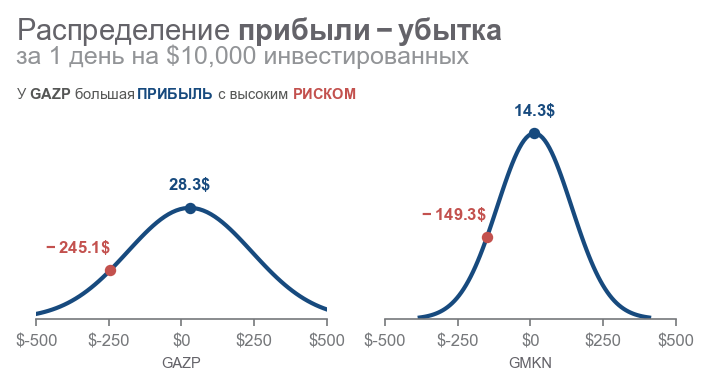

In [7]:
def plot_gain_loss_curve(ax, stock_idx: int):
    rv = share_gain_rvs[stock_idx]
    gain_loc, var_loc = expected_gains[stock_idx], -values_at_risk[stock_idx]
    gain_prob, var_prob = rv.pdf(gain_loc), rv.pdf(var_loc)

    plot_x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
    ax.plot(plot_x, rv.pdf(plot_x), linewidth=2, color=BLUE1, zorder=1)
    ax.scatter([gain_loc], [gain_prob], s=20, color=BLUE1, clip_on=False)
    ax.scatter(
        [var_loc], [var_prob], s=20, color=RED1, clip_on=False, zorder=2)
    ax.text(gain_loc, gain_prob, f'$\\bf{gain_loc:.1f}\$$\n',
            fontsize=8, color=BLUE1, horizontalalignment='center')
    ax.text(var_loc, var_prob, f'$\\bf{var_loc:.1f}\$$\n',
            fontsize=8, color=RED1, horizontalalignment='right')
    ax.set_ylim([0, 0.004])
    ax.set_xlim([-500, 500])
    ax.tick_params(left=False, labelleft=False)
    for spine_name in ['right', 'top', 'left']:
        ax.spines[spine_name].set_visible(False)
    for item in ax.get_xticklabels():
        item.set_color(GRAY5)
        item.set_fontsize(8)
    ax.tick_params(color=GRAY5)
    ax.spines['bottom'].set_color(GRAY5)
    plt.setp(ax,
             xticks=[-500, -250, 0, 250, 500],
             xticklabels=['$-500', '$-250', '$0', '$250', '$500'])
    ax.set_xlabel(f'{stock_names[stock_idx]}', color=GRAY4, fontsize=7)


fig, axarr = plt.subplots(1, 2, figsize=(5.5, 2.1), dpi=150)
plot_gain_loss_curve(axarr[0], 1)
plot_gain_loss_curve(axarr[1], 2)
axarr[0].text(-570, 0.0047,
        # 'Gain (loss) over 1 day on $10,000 invested',
        'Распределение $\\bf{прибыли-убытка}$',
        color=GRAY4, fontsize=14)
axarr[0].text(-570, 0.0043,
              'за 1 день на $10,000 инвестированных', color=GRAY7, fontsize=12)

#axarr[0].text(-570, 0.0043,
#              # 'Gain (loss) over 1 day on $10,000 invested',
#              'Распределение прибыль-убыток за 1 день на $10,000',
#              fontsize=12, color=GRAY4)
rainbow_text(
    -570, 0.0037,
    # '$\\bf{GAZP}$ offers higher ||$\\bf{GAIN}$|| '
    # 'vs $\\bf{GMKN}$ at higher ||$\\bf{VAR}$',
    'У $\\bf{GAZP}$ большая ||$\\bf{ПРИБЫЛЬ}$|| '
    'с высоким ||$\\bf{РИСКОМ}$',
    [[GRAY3, BLUE1, GRAY3, RED1]], spacing=22, ax=axarr[0], fontsize=7)

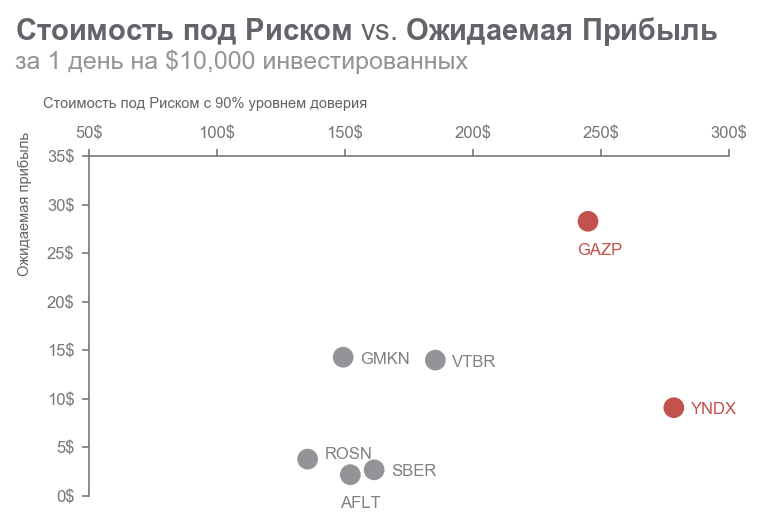

In [8]:
def plot_var_vs_expected_gain():
    colors = [GRAY7, RED1, GRAY7, GRAY7, GRAY7, GRAY7, RED1]
    txt_colors = [GRAY6, RED1, GRAY6, GRAY6, GRAY6, GRAY6, RED1]
    offsets = [
        (-5, -16), (-5, -16), (8, -3), (8, 0), (8, -3), (8, -3), (8, -3)]

    fig, ax = plt.subplots(figsize=(5.5, 3), dpi=150)
    ax.scatter(values_at_risk, expected_gains, color=colors, s=80)
    for i, name in enumerate(stock_names):
        ax.annotate(
            name, [values_at_risk[i], expected_gains[i]], xytext=offsets[i],
            textcoords='offset points', color=txt_colors[i], fontsize=8)
    x_ticks = list(range(50, 350, 50))
    y_ticks = list(range(0, 40, 5))
    plt.setp(ax, xticks=x_ticks, yticks=y_ticks,
             xticklabels=[str(i)+'$' for i in x_ticks],
             yticklabels=[str(i)+'$' for i in y_ticks])
    ax.set_ylim(0, 35)
    ax.set_xlim(50, 300)
    ax.tick_params(top='on', bottom='off', labelbottom='off', labeltop='on')
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY5)
    ax.tick_params(color=GRAY5)
    ax.spines['top'].set_color(GRAY5)
    ax.spines['left'].set_color(GRAY5)
    ax.text(22, 36.4,
            # 'Expected gain',
            'Ожидаемая прибыль',
            color=GRAY4, rotation='vertical',  fontsize=7)
    ax.text(32, 40,
            # '90% confidence Value at Risk',
            'Стоимость под Риском с 90% уровнем доверия',
            color=GRAY4, fontsize=7)
    ax.text(21, 47,
            # 'One day $\\bf{Value\ at\ Risk}$ vs. $\\bf{Expected\ Gain}$'
            # ' on \$10,000 invested',
            '$\\bf{Стоимость\ под\ Риском}$ vs. $\\bf{Ожидаемая\ Прибыль}$',
            color=GRAY4, fontsize=14)
    ax.text(21, 44, 'за 1 день на $10,000 инвестированных', color=GRAY7, fontsize=12)
    return ax


_ = plot_var_vs_expected_gain()

### Optimization

In [9]:
# one day return variance-covariance matrix: at ij we have the covariance
# between return of share_i and share_j, at ii we have variance of share_i,
# where variance is squared volatility
var_cov = np.array([
    [1.45e-04, 4.22e-05, 9.96e-06, 2.79e-06, 3.12e-06, 1.18e-05, 4.08e-05],
    [4.22e-05, 4.55e-04, 3.63e-05, 4.94e-05, 9.69e-05, 4.73e-05, 4.82e-05],
    [9.96e-06, 3.63e-05, 1.63e-04, 2.01e-05, 2.85e-05, 4.92e-06, 1.00e-05],
    [2.79e-06, 4.94e-05, 2.01e-05, 1.18e-04, 4.20e-05, 2.07e-05, 4.11e-06],
    [3.12e-06, 9.69e-05, 2.85e-05, 4.20e-05, 1.64e-04, 2.67e-05, 4.98e-06],
    [1.18e-05, 4.73e-05, 4.92e-06, 2.07e-05, 2.67e-05, 2.42e-04,-4.95e-06],
    [4.08e-05, 4.82e-05, 1.00e-05, 4.11e-06, 4.98e-06,-4.95e-06, 5.04e-04]])

In [10]:
# we need to distribute $10,000 among 7 stocks, stock_shares is proportions
# of investment amount, 0.3 at position 1 mean 30% to GAZP
stock_shares = cp.Variable(N)
# variance means risk, we will do optimization with different values of
# "risk tolerance"
variance_aversion = cp.Parameter(nonneg=True)

# whole portfolio expected return depends on how we will distribute our money
portfolio_expected_return = expected_returns.T @ stock_shares
# whole portfolio variance depends on money distribution and var-cov matrix
portfolio_variance = cp.quad_form(stock_shares, var_cov)

# our objective is to maximize expected return under risk tolerance parameter
objective = cp.Maximize(
    portfolio_expected_return - variance_aversion * portfolio_variance)
# we need to invest all our money and investment is positive amount for stock
constraints = [cp.sum(stock_shares) == 1,
               stock_shares >= 0]
# the task is to optimize objective function under constraints
problem = cp.Problem(objective, constraints)


def optimize_with_aversion(variance_aversion_value: float):
    """Optimizes portfolio under variance aversion value and calculates
    Value at Risk and Expected Gain for the resulting portfolio.

    Parameters
    __________
    variance_aversion_value :
        Penalty for variance (risk aversion).
    """
    variance_aversion.value = variance_aversion_value
    problem.solve()
    # calculate expected gain and value at risk
    portfolio_expected_gain = \
        investment_amount * portfolio_expected_return.value
    rv = norm(loc=portfolio_expected_gain,
              scale=investment_amount*float(cp.sqrt(portfolio_variance).value))
    portfolio_value_at_risk = np.abs(rv.ppf(0.1))
    return portfolio_value_at_risk, portfolio_expected_gain, stock_shares.value


# prepare 100 different penalty values
aversions = np.logspace(-2, 3, num=100)
result = list(map(optimize_with_aversion, aversions))

In [11]:
# VaR below 150 is Ok for us
var, gain, shares = next(r for r in result if r[0] < 150)
selected_stocks = np.squeeze(np.argwhere(~np.isclose(shares, 0)))
selected_shares_text = '\n'.join(
    f'{name}: {100*share:.0f}%'
    for name, share in zip(stock_names[selected_stocks],
                           shares[selected_stocks]))
print(f'VaR: ${var:.1f}, Expected Gain: ${gain:.1f}')
print(selected_shares_text)

VaR: $144.0, Expected Gain: $21.6
GAZP: 52%
GMKN: 31%
VTBR: 17%


Text(255,27,'$\\bf{граница}$\n$\\bf{эффективности}$')

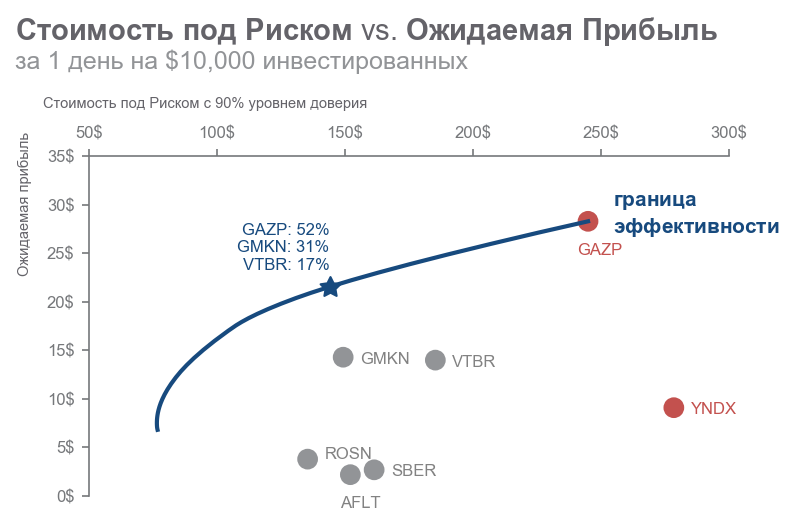

In [12]:
ax = plot_var_vs_expected_gain()
x_plot = [rec[0] for rec in result]
y_plot = [rec[1] for rec in result]
ax.plot(x_plot, y_plot, color=BLUE1, linewidth=2)
ax.scatter([var], [gain], s=100, c=BLUE1, marker=(5, 1))
ax.text(var, gain, selected_shares_text+'\n', horizontalalignment='right',
        fontsize=8, color=BLUE1)
ax.text(255, 27, '$\\bf{граница}$\n$\\bf{эффективности}$', color=BLUE1)

## Max Heart-Rate

In [19]:
# max heart rates measured in laboratory
laboratory_test_data = np.array([
    [18, 198], [19, 190], [24, 198], [26, 193], [29, 185],
    [29, 185], [33, 181], [35, 186], [44, 178], [48, 166],
    [53, 162], [56, 168], [64, 162], [70, 210], [76, 151]])

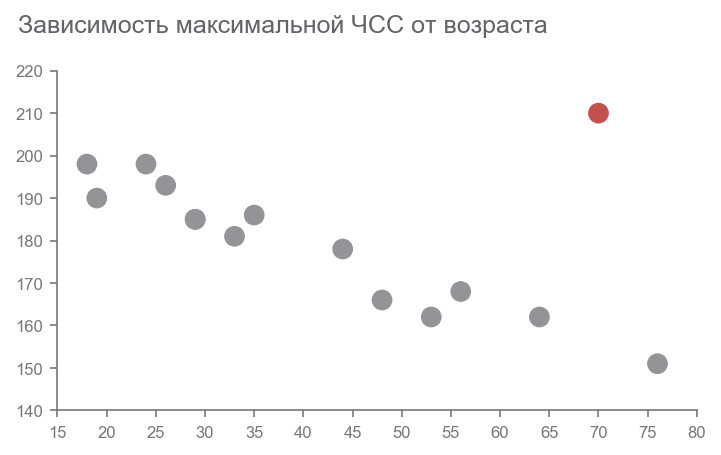

In [36]:
def plot_max_heart_rates_scatter():
    colors = [GRAY7]*13 + [RED1] + [GRAY7]
    fig, ax = plt.subplots(figsize=(5.5, 3), dpi=150)
    ax.scatter(laboratory_test_data[:, 0], laboratory_test_data[:, 1],
               color=colors, s=80)
    x_ticks = list(range(15, 85, 5))
    y_ticks = list(range(140, 230, 10))
    plt.setp(ax, xticks=x_ticks, yticks=y_ticks)
    ax.set_ylim(140, 220)
    ax.set_xlim(15, 80)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for i in ax.get_yticklabels() + ax.get_xticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY5)
    ax.tick_params(color=GRAY5)
    ax.spines['bottom'].set_color(GRAY5)
    ax.spines['left'].set_color(GRAY5)
    ax.text(11, 229, 'Зависимость максимальной ЧСС от возраста',
            color=GRAY4, fontsize=12)
    return ax


_ = plot_max_heart_rates_scatter()

In [14]:
intercept = cp.Variable()
coefficient = cp.Variable()
max_heart_rate_hat = intercept + ages*coefficient
residuals = max_heart_rates - max_heart_rate_hat
#loss = cp.sum_squares(residuals)
#loss = cp.sum(cp.abs(residuals))
loss = cp.sum(cp.huber(residuals, 50))
problem = cp.Problem(cp.Minimize(loss))
problem.solve()

2590.8055938573016

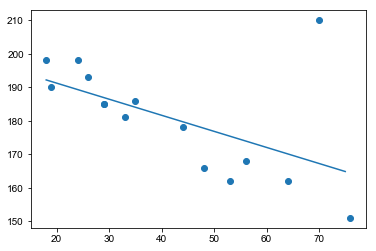

In [56]:
x = np.linspace(18, 75, 50)
y = intercept.value + x*coefficient.value
plt.scatter(ages, max_heart_rates)
plt.plot(x, y)

## Prostate Cancer

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [17]:
# we will predict lpsa (log prostate specific antigen)
target = 'lpsa'
# based on the following features
features = ['lcavol', 'lweight', 'age', 'lbph',
            'svi', 'lcp', 'gleason', 'pgg45']
# load training and test data from the file
df = pd.read_csv("../data/Prostate Cancer.txt")
df.head()

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [18]:
is_train = df.train == 'T'
X, y = df[features].values, df[target].values
X_train, y_train = X[is_train], y[is_train]
X_test, y_test = X[~is_train], y[~is_train]
scaler = StandardScaler().fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
p = X_train.shape[1]

In [89]:
intercept = cp.Variable()
coefficients = cp.Variable(p)

y_hat = intercept + X_train @ coefficients
#loss = cp.sum_squares(y_train - y_hat)
loss = cp.sum(cp.abs(y_train - y_hat))
problem = cp.Problem(cp.Minimize(loss))
problem.solve()

32.03033856565688

In [90]:
y_test_hat = intercept.value + X_test @ coefficients.value
mean_squared_error(y_test, y_test_hat)

0.4946618476844652

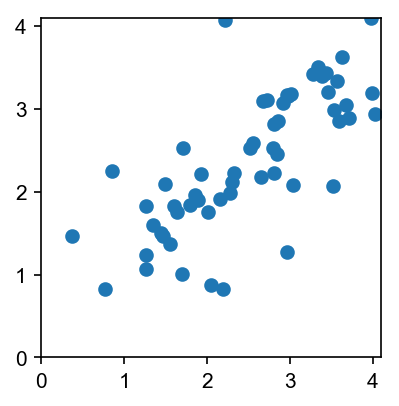

In [91]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(y_train, y_hat.value)
ax.set_xlim(0, 4.1)
ax.set_ylim(0, 4.1)
ax.set_aspect('equal')